# **Data Reading & Sampling**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [3]:
chunk_size = 100000  
rus = RandomUnderSampler(random_state=42)
undersampled_data = pd.DataFrame()

# ✅ Read the CSV from the same folder as your notebook
for chunk in pd.read_csv("trans.csv", chunksize=chunk_size):
    X_chunk = chunk.drop("Is Laundering", axis=1)
    y_chunk = chunk["Is Laundering"]
    
    # Only process if both classes exist in the chunk
    if len(y_chunk.unique()) > 1:
        X_rus, y_rus = rus.fit_resample(X_chunk, y_chunk)
        chunk_rus = pd.concat([X_rus, y_rus], axis=1)
        undersampled_data = pd.concat([undersampled_data, chunk_rus], ignore_index=True)

print("✅ Undersampling complete! Final data shape:", undersampled_data.shape)

✅ Undersampling complete! Final data shape: (10354, 11)


In [4]:
df = undersampled_data

# **Data Understanding**

In [5]:
df.head(10)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:22,2845,8048442A0,2845,8048442A0,8474.24,US Dollar,8474.24,US Dollar,Reinvestment,0
1,2022/09/01 00:16,13145,803EA82D0,13145,803EA82D0,351811.03,US Dollar,351811.03,US Dollar,Reinvestment,0
2,2022/09/01 00:13,23537,808094A70,23537,808094A70,18.71,US Dollar,18.71,US Dollar,Reinvestment,0
3,2022/09/01 00:28,70,100428660,1601,8010D01B0,40228.29,US Dollar,40228.29,US Dollar,Cheque,0
4,2022/09/01 00:23,11318,800C4B390,11318,800C4B390,40068.30,US Dollar,40068.30,US Dollar,Reinvestment,0
5,2022/09/01 00:21,70,100428660,1124,800825340,389769.39,US Dollar,389769.39,US Dollar,Cheque,1
6,2022/09/01 00:03,70,100428660,11474,805B716C0,29024.33,US Dollar,29024.33,US Dollar,Credit Card,1
7,2022/09/01 00:01,70,100428660,15980,80B39E7B0,792.92,US Dollar,792.92,US Dollar,Credit Card,1
8,2022/09/01 00:03,70,100428660,113798,80DC756E0,13171425.53,US Dollar,13171425.53,US Dollar,Cheque,1
9,2022/09/01 00:23,70,100428660,32375,80E480620,14288.83,US Dollar,14288.83,US Dollar,Cash,1


In [6]:
df.shape

(10354, 11)

In [7]:
df.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

In [8]:
df.columns = [col.replace(' ', '_').replace('.', '_').lower() for col in df.columns]
df.columns

Index(['timestamp', 'from_bank', 'account', 'to_bank', 'account_1',
       'amount_received', 'receiving_currency', 'amount_paid',
       'payment_currency', 'payment_format', 'is_laundering'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10354 entries, 0 to 10353
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           10354 non-null  object 
 1   from_bank           10354 non-null  int64  
 2   account             10354 non-null  object 
 3   to_bank             10354 non-null  int64  
 4   account_1           10354 non-null  object 
 5   amount_received     10354 non-null  float64
 6   receiving_currency  10354 non-null  object 
 7   amount_paid         10354 non-null  float64
 8   payment_currency    10354 non-null  object 
 9   payment_format      10354 non-null  object 
 10  is_laundering       10354 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 889.9+ KB


In [10]:
df.isnull().sum()

timestamp             0
from_bank             0
account               0
to_bank               0
account_1             0
amount_received       0
receiving_currency    0
amount_paid           0
payment_currency      0
payment_format        0
is_laundering         0
dtype: int64

In [11]:
df['is_laundering'].value_counts()

is_laundering
0    5177
1    5177
Name: count, dtype: int64

The **undersampling** procedure has demonstrated its effectiveness by successfully **equalizing the proportions** of the 'is_laundering' class, resulting in an **equal distribution between the classes**. This balanced representation signifies that the undersampling technique effectively reduced the dataset's class imbalance, ensuring that both the positive and negative classes of 'is_laundering' are now equally represented. This balanced distribution is crucial in **mitigating biases** and **enhancing the model's ability to learn** and **make predictions accurately** across both classes, thereby improving the model's performance and reliability in detecting money laundering activities.

Displaying an example of money laundering occurrence: **[is_laundering] = 1**

In [12]:
df_laundering = df[df['is_laundering'] == 1]
df_laundering.head(10)

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
5,2022/09/01 00:21,70,100428660,1124,800825340,389769.39,US Dollar,389769.39,US Dollar,Cheque,1
6,2022/09/01 00:03,70,100428660,11474,805B716C0,29024.33,US Dollar,29024.33,US Dollar,Credit Card,1
7,2022/09/01 00:01,70,100428660,15980,80B39E7B0,792.92,US Dollar,792.92,US Dollar,Credit Card,1
8,2022/09/01 00:03,70,100428660,113798,80DC756E0,13171425.53,US Dollar,13171425.53,US Dollar,Cheque,1
9,2022/09/01 00:23,70,100428660,32375,80E480620,14288.83,US Dollar,14288.83,US Dollar,Cash,1
30,2022/09/01 00:23,231004,812EE86F0,21940,812EE89C0,3401.73,US Dollar,3401.73,US Dollar,ACH,1
31,2022/09/01 00:17,70,100428660,152980,8140702D0,6892.43,US Dollar,6892.43,US Dollar,Credit Card,1
32,2022/09/01 00:26,70,1004286A8,2591,800926A30,37145.30,Euro,37145.30,Euro,Cheque,1
33,2022/09/01 00:06,21174,800737690,12,80011F990,2848.96,Euro,2848.96,Euro,ACH,1
34,2022/09/01 04:33,21174,800737690,20,80020C5B0,8630.40,Euro,8630.40,Euro,ACH,1


Our initial hypothesis posited that money laundering occurs when there's a **disparity** between **[amount_received]** and **[amount_paid]**. However, subsequent filtering and analysis have **disproven our hypothesis**.

In [13]:
different_amounts = df[df['amount_received'] != df['amount_paid']]
different_amounts.head(100)

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
112,2022/09/01 01:00,122946,8087EF3D0,122946,8087EF3D0,2724.39,US Dollar,2109.22,UK Pound,ACH,0
118,2022/09/01 00:18,314359,8127EA160,314359,8127EA160,9353.19,Saudi Riyal,183129.12,Rupee,ACH,0
137,2022/09/01 01:53,222363,80F701FA0,222363,80F701FA0,575.16,Euro,673.96,US Dollar,ACH,0
422,2022/09/01 05:33,1674,80042F4A0,1674,80042F4A0,24512.75,Australian Dollar,17350.48,US Dollar,ACH,0
455,2022/09/01 07:02,20,80681A170,20,80681A170,148.76,US Dollar,126.95,Euro,ACH,0
...,...,...,...,...,...,...,...,...,...,...,...
10006,2022/09/10 17:52,1267,803711710,1267,803711710,41.66,Euro,326.94,Yuan,ACH,0
10075,2022/09/10 15:13,131928,81080F2E0,131928,81080F2E0,22.38,US Dollar,149.92,Yuan,ACH,0
10105,2022/09/10 15:58,19705,80B16F6E0,19705,80B16F6E0,141.36,US Dollar,946.80,Yuan,ACH,0
10117,2022/09/10 14:54,33727,80C66DAE0,33727,80C66DAE0,2637.67,US Dollar,55768.52,Mexican Peso,ACH,0


As it turns out, the divergence in values between **[amount_received]** and **[amount_paid]** is attributed to the discrepancy in **[receiving_currency]** and **[payment_currency]**. Additionally, a majority of transactions utilize the **'ACH'** payment format.

In [14]:
same_currency = (df['amount_received'] != df['amount_paid']) & (df['receiving_currency'] == df['payment_currency'])
same_currency.value_counts()

False    10354
Name: count, dtype: int64

We also found out that there are no transactions that have different **[amount_received]** and **[amount_paid]** while the **[receiving_currency]** and **[payment_currency]** is the same.

In [15]:
df['payment_format'].value_counts()

payment_format
ACH             5177
Cheque          2309
Credit Card     1643
Cash             586
Reinvestment     247
Bitcoin          207
Wire             185
Name: count, dtype: int64

In [16]:
df_laundering['payment_format'].value_counts()

payment_format
ACH            4483
Cheque          324
Credit Card     206
Cash            108
Bitcoin          56
Name: count, dtype: int64

**Money laundering** tends to occur when utilizing the [payment_format] **ACH (Automated Clearing House)**: an electronic payment method enabling fund transfers between banks electronically, commonly used for routine payments such as monthly bill payments.

In [17]:
df['payment_currency'].value_counts()

payment_currency
US Dollar            3887
Euro                 2581
Saudi Riyal           467
Swiss Franc           425
Yuan                  391
Rupee                 362
Shekel                312
Yen                   295
UK Pound              293
Ruble                 285
Australian Dollar     255
Canadian Dollar       251
Bitcoin               207
Mexican Peso          201
Brazil Real           142
Name: count, dtype: int64

In [18]:
df_laundering['payment_currency'].value_counts()

payment_currency
US Dollar            1912
Euro                 1372
Saudi Riyal           374
Swiss Franc           193
Yuan                  184
Rupee                 167
Yen                   155
Ruble                 133
UK Pound              132
Canadian Dollar       128
Australian Dollar     127
Shekel                 95
Mexican Peso           92
Brazil Real            57
Bitcoin                56
Name: count, dtype: int64

**Money laundering** tends to occur when utilizing [payment_currency] **US Dollar**.

In [19]:
df['receiving_currency'].value_counts()

receiving_currency
US Dollar            3877
Euro                 2583
Saudi Riyal           469
Swiss Franc           429
Yuan                  384
Rupee                 360
Shekel                317
Yen                   295
UK Pound              292
Ruble                 288
Australian Dollar     259
Canadian Dollar       251
Bitcoin               208
Mexican Peso          199
Brazil Real           143
Name: count, dtype: int64

In [20]:
df_laundering['receiving_currency'].value_counts()

receiving_currency
US Dollar            1912
Euro                 1372
Saudi Riyal           374
Swiss Franc           193
Yuan                  184
Rupee                 167
Yen                   155
Ruble                 133
UK Pound              132
Canadian Dollar       128
Australian Dollar     127
Shekel                 95
Mexican Peso           92
Brazil Real            57
Bitcoin                56
Name: count, dtype: int64

The same trend is observed in [receiving_currency], where **Money laundering** tends to occur when using **US Dollar**.

# **Splitting the Data (Train & Test)**

In [21]:
input_df  = df.drop('is_laundering', axis = 1)
output_df = df['is_laundering']

In [22]:
x_train, x_test, y_train, y_test = train_test_split(input_df, output_df, test_size = 0.2, random_state = 42)

# **Exploratory Data Analysis**

### Numerical Data 

<Axes: xlabel='amount_received'>

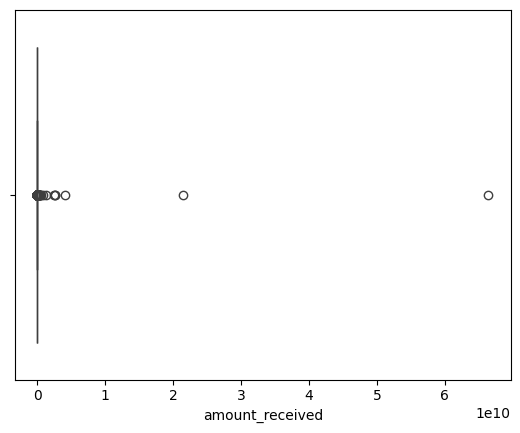

In [23]:
sns.boxplot(x= x_train['amount_received'])

In [24]:
q1 = x_train['amount_received'].quantile(0.25)
q3 = x_train['amount_received'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = (x_train['amount_received'] < lower_bound) | (x_train['amount_received'] > upper_bound)

In [25]:
num_outliers = outliers.sum()
percentage_outliers = (num_outliers / len(x_train)) * 100
print("Amount Received")
print(f"Number of outliers: {num_outliers}")
print(f"Percentage of outliers: {percentage_outliers}%")

Amount Received
Number of outliers: 1316
Percentage of outliers: 15.887963298321864%


<Axes: xlabel='amount_paid'>

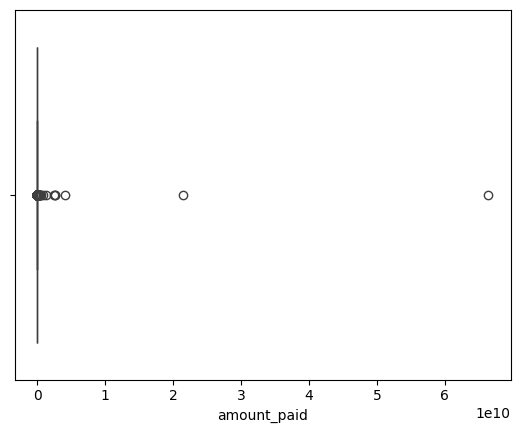

In [26]:
sns.boxplot(x=x_train['amount_paid'])

In [27]:
q1_paid = x_train['amount_paid'].quantile(0.25)
q3_paid = x_train['amount_paid'].quantile(0.75)
iqr_paid = q3_paid - q1_paid
lower_bound_paid = q1_paid - 1.5 * iqr_paid
upper_bound_paid = q3_paid + 1.5 * iqr_paid
outliers_paid = (x_train['amount_paid'] < lower_bound_paid) | (x_train['amount_paid'] > upper_bound_paid)

In [28]:
num_outliers_paid = outliers_paid.sum()
percentage_outliers_paid = (num_outliers_paid / len(x_train)) * 100
print("Amount Paid")
print(f"Number of outliers: {num_outliers_paid}")
print(f"Percentage of outliers: {percentage_outliers_paid}%")

Amount Paid
Number of outliers: 1318
Percentage of outliers: 15.912109139200773%


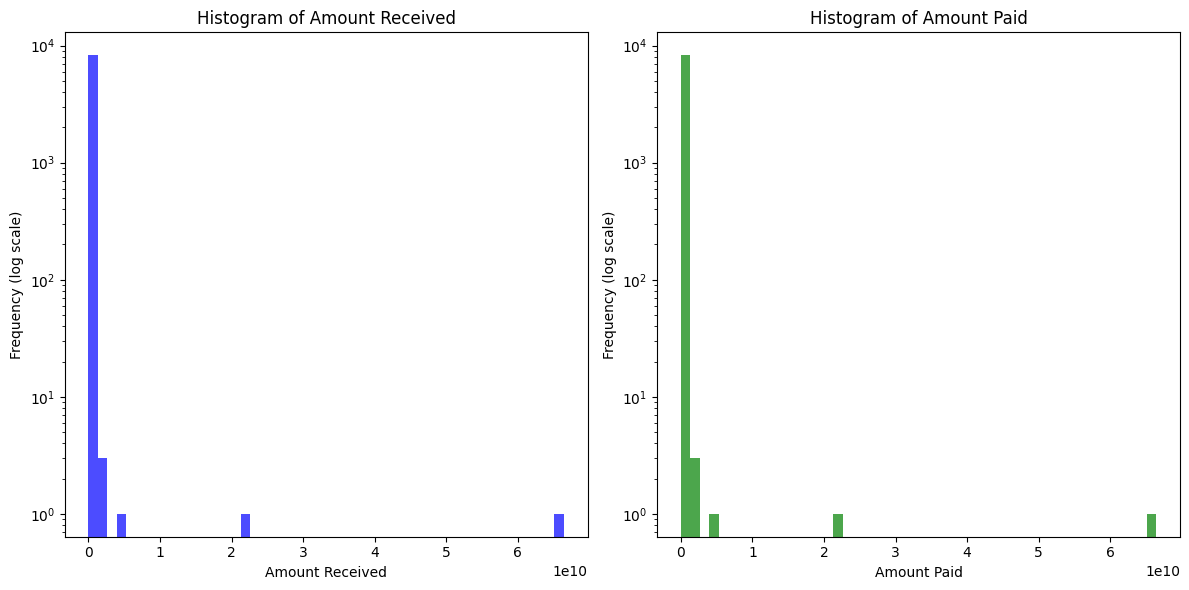

In [29]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_train['amount_received'], bins=50, color='blue', alpha=0.7, log=True)
plt.title('Histogram of Amount Received')
plt.xlabel('Amount Received')
plt.ylabel('Frequency (log scale)')

plt.subplot(1, 2, 2)
plt.hist(x_train['amount_paid'], bins=50, color='green', alpha=0.7, log=True)
plt.title('Histogram of Amount Paid')
plt.xlabel('Amount Paid')
plt.ylabel('Frequency (log scale)')

plt.tight_layout()
plt.show()

**From the histograms, we can observe the following:**

1. **Skewed Distribution:** Both amount_received and amount_paid are **right-skewed**, indicating that the **majority** of transactions involve **smaller amounts**, with a relatively small number of transactions involving very large amounts.
2. **Presence of Outliers:** The **long tails to the right** suggest the presence of **outliers.** These are transactions where the amounts are significantly higher than the typical transaction in the dataset.
3. **Comparability:** The two plots side by side allow for a direct comparison between the distributions of amount_received and amount_paid. They appear to follow a **similar distribution pattern**, suggesting a **potential correlation between these two variables.**

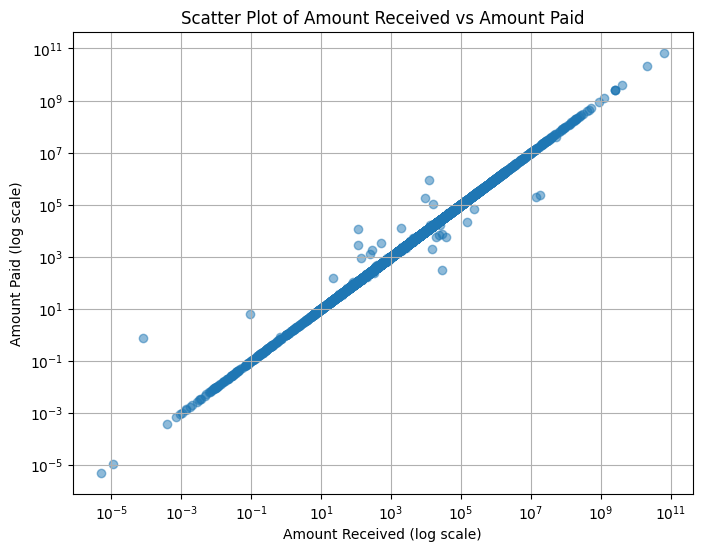

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train['amount_received'], x_train['amount_paid'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('Scatter Plot of Amount Received vs Amount Paid')
plt.xlabel('Amount Received (log scale)')
plt.ylabel('Amount Paid (log scale)')
plt.grid(True)
plt.show()

**From the histograms, we can observe the following:**
1. **Positive Linear Relationship:** There is a **clear positive correlation between the two variables.** As amount_received increases, amount_paid also increases, which is evident from the **upward trend** in the data points.
2. **Outliers:** There are a few points that **stray from the main cluster**, indicating possible outliers in the dataset.
3. **Implications for Analysis:** The **strong linear pattern** suggests that amount_received and amount_paid are closely related, which could be expected in financial transaction data. However, the presence of outliers may necessitate further investigation, especially if the goal is to detect fraudulent activity such as money laundering.

This scatter plot is a powerful diagnostic tool, as it not only confirms the relationship between the two variables but also highlights areas where the data does not conform to the expected pattern, which could be of particular interest in **fraud detection** or **risk management scenarios.**

### Categorical Data 

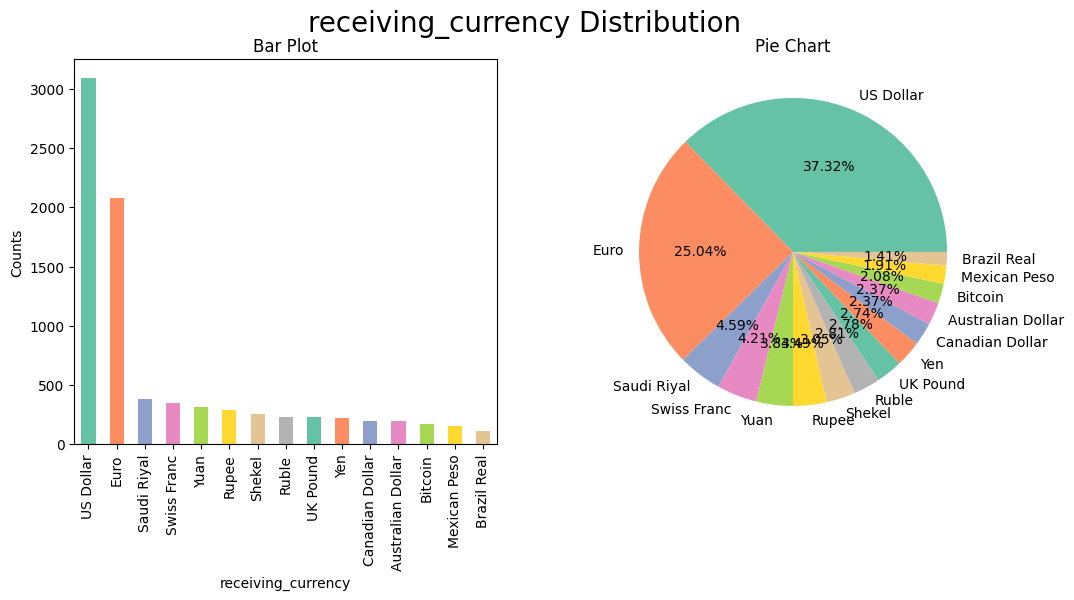

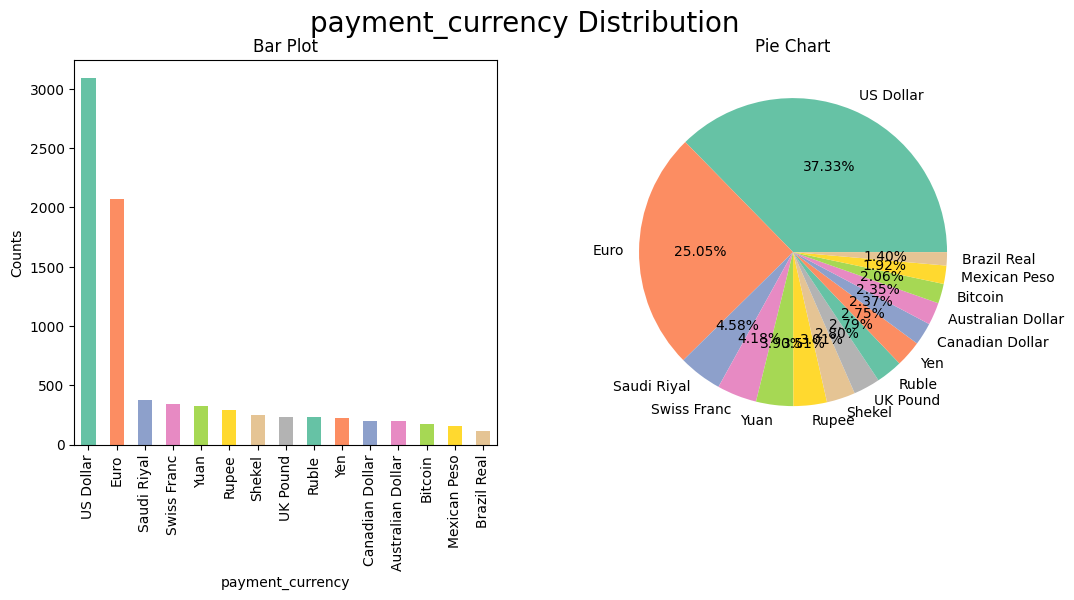

In [31]:
columns_to_plot = ['receiving_currency', 'payment_currency']
palette = sns.color_palette("Set2")

for column in columns_to_plot:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'{column} Distribution', fontsize=20)

    plt.subplot(1, 2, 1)
    x_train[column].value_counts().plot(kind='bar', color=palette)
    plt.title('Bar Plot')
    plt.xlabel(column)
    plt.ylabel('Counts')

    plt.subplot(1, 2, 2)
    x_train[column].value_counts().plot(kind='pie', autopct="%.2f%%", colors=palette)
    plt.title('Pie Chart')
    plt.ylabel('')

    plt.show()

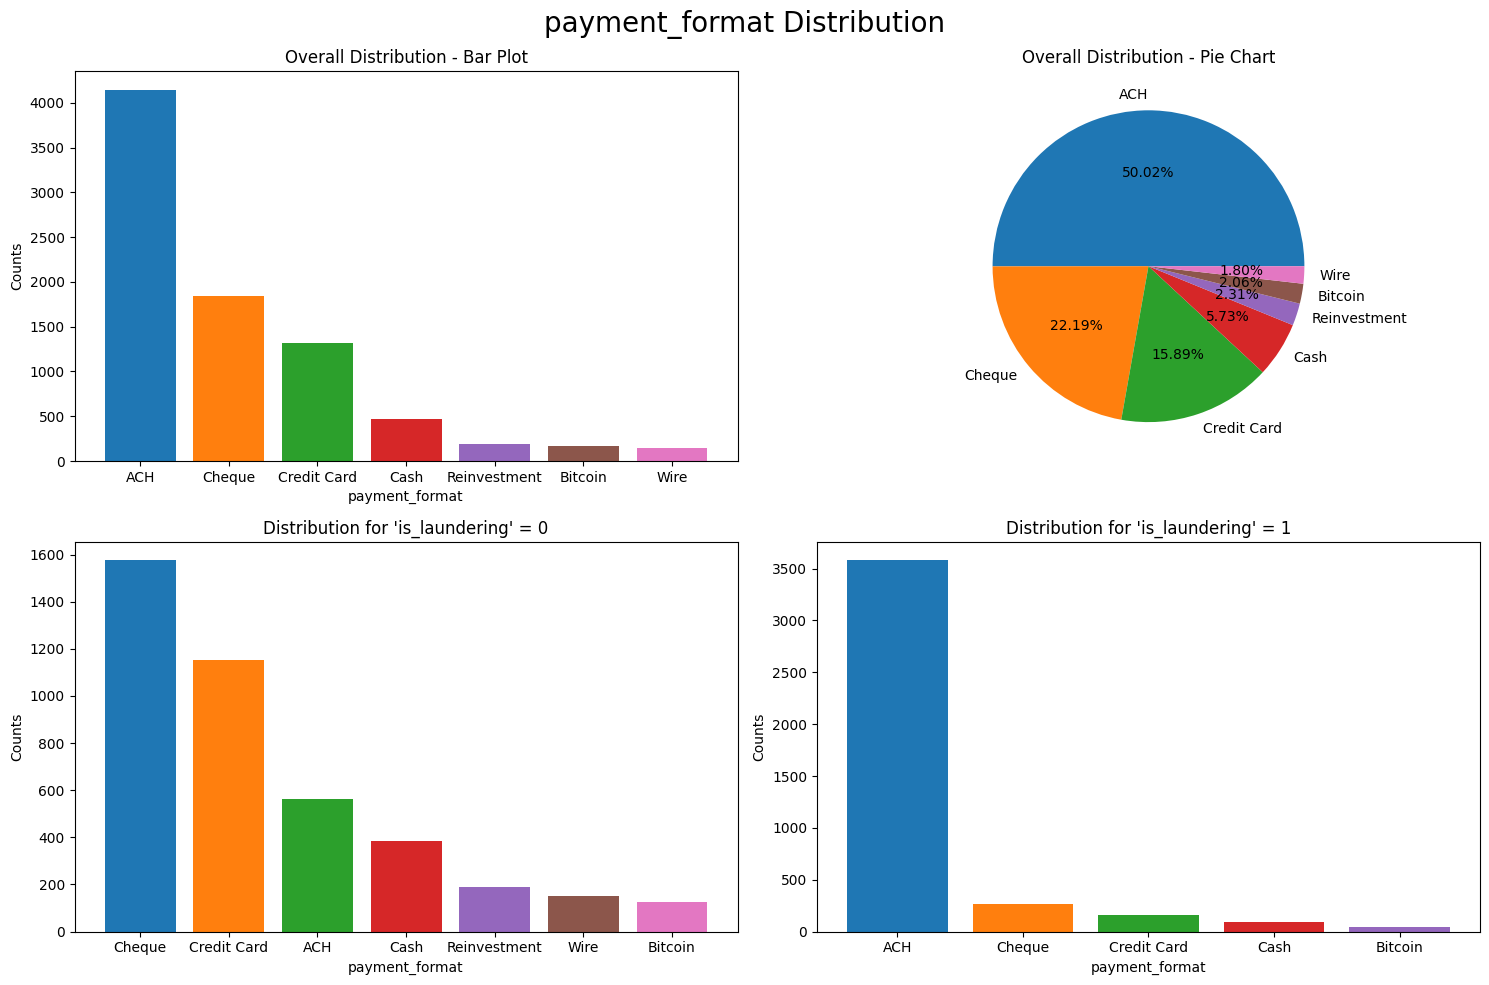

In [32]:
column = 'payment_format'
palette = sns.color_palette("tab10")

fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 
fig.suptitle(f'{column} Distribution', fontsize=20)

axs[0, 0].bar(x_train[column].value_counts().index, x_train[column].value_counts().values, color=palette)
axs[0, 0].set_title('Overall Distribution - Bar Plot')
axs[0, 0].set_xlabel(column)
axs[0, 0].set_ylabel('Counts')

axs[0, 1].pie(x_train[column].value_counts(), labels=x_train[column].value_counts().index, autopct="%.2f%%", colors=palette)
axs[0, 1].set_title('Overall Distribution - Pie Chart')

x_train_laundering_0 = x_train[y_train == 0]
axs[1, 0].bar(x_train_laundering_0[column].value_counts().index, x_train_laundering_0[column].value_counts().values, color=palette)
axs[1, 0].set_title("Distribution for 'is_laundering' = 0")
axs[1, 0].set_xlabel(column)
axs[1, 0].set_ylabel('Counts')

x_train_laundering_1 = x_train[y_train == 1]
axs[1, 1].bar(x_train_laundering_1[column].value_counts().index, x_train_laundering_1[column].value_counts().values, color=palette)
axs[1, 1].set_title("Distribution for 'is_laundering' = 1")
axs[1, 1].set_xlabel(column)
axs[1, 1].set_ylabel('Counts')

plt.tight_layout()
plt.show()

# **Feature Engineering**

## **Feature Extraction**

In [34]:
x_train.head(10)

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format
1047,2022/09/01 19:15,213,809184EB0,25665,8096F2420,9005638.90,Canadian Dollar,9005638.90,Canadian Dollar,Cheque
7361,2022/09/08 05:39,16354,805BDDD50,2915,80AC411A0,241.91,Euro,241.91,Euro,Cheque
9833,2022/09/10 10:38,22828,802395720,5836,802395810,4963.04,US Dollar,4963.04,US Dollar,ACH
5216,2022/09/06 05:15,27,80C5D40B0,1132,80CB3C8A0,53515.28,Mexican Peso,53515.28,Mexican Peso,ACH
766,2022/09/05 16:20,211,808E44B10,28800,811097150,783.75,US Dollar,783.75,US Dollar,ACH
1144,2022/09/03 02:24,16333,802CDC780,214621,8072203B0,10622.81,US Dollar,10622.81,US Dollar,ACH
5035,2022/09/05 18:04,43049,810628440,43049,810628760,8916.80,Shekel,8916.80,Shekel,ACH
2377,2022/09/03 06:50,110,80CF52AB0,217125,806D73DD0,650347.10,Ruble,650347.10,Ruble,ACH
4587,2022/09/05 10:06,116715,80992D8D0,16535,80AFCD6D0,1402.51,US Dollar,1402.51,US Dollar,Cheque
9502,2022/09/10 06:27,22828,80118FBB0,23885,8017A5F70,8691.02,US Dollar,8691.02,US Dollar,Cheque


In [35]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8283 entries, 1047 to 7270
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           8283 non-null   object 
 1   from_bank           8283 non-null   int64  
 2   account             8283 non-null   object 
 3   to_bank             8283 non-null   int64  
 4   account_1           8283 non-null   object 
 5   amount_received     8283 non-null   float64
 6   receiving_currency  8283 non-null   object 
 7   amount_paid         8283 non-null   float64
 8   payment_currency    8283 non-null   object 
 9   payment_format      8283 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 711.8+ KB


In this feature extraction process, we **decompose** the **timestamp** into distinct components including **year, month, day, hour, and minute**. This breakdown allows us to treat each component as an individual numeric variable. The rationale behind this approach is to **facilitate analysis** and **potentially uncover new insights** from the dataset. By isolating these temporal elements, we aim to gain a more granular understanding of the data, enabling enhanced analytical capabilities and the potential discovery of valuable patterns or relationships within the information.

In [36]:
x_train['timestamp'] = pd.to_datetime(x_train['timestamp'])
x_test['timestamp'] = pd.to_datetime(x_test['timestamp'])

In [37]:
x_train['year'] = x_train['timestamp'].dt.year
x_test['year'] = x_test['timestamp'].dt.year

min_year = x_train['year'].min()
max_year = x_train['year'].max()
print(min_year, max_year)

2022 2022


In [38]:
x_train['year'].value_counts()

year
2022    8283
Name: count, dtype: int64

In [39]:
x_train[x_train['year'] == 2023].head()

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,year


In [40]:
indices_to_drop_train = x_train[x_train['year'] == 2023].index
indices_to_drop_test = x_test[x_test['year'] == 2023].index

x_train = x_train[x_train['year'] != 2023]
x_test = x_test[x_test['year'] != 2023]

y_train = y_train.drop(indices_to_drop_train, axis=0)
y_test = y_test.drop(indices_to_drop_test, axis=0)

x_train['year'].value_counts()

year
2022    8283
Name: count, dtype: int64

In [41]:
print("x_train:", len(x_train))
print("y_train:", len(y_train))
print("x_test:", len(x_test))
print("y_test:", len(y_test))

x_train: 8283
y_train: 8283
x_test: 2071
y_test: 2071


In [42]:
x_train['month'] = x_train['timestamp'].dt.month
x_test['month'] = x_test['timestamp'].dt.month

min_month = x_train['month'].min()
max_month = x_train['month'].max()
print(min_month, max_month)

9 9


In [43]:
x_train['month'].value_counts()

month
9    8283
Name: count, dtype: int64

In [44]:
x_train[x_train['month'] == 12].head()

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,year,month


In [45]:
indices_to_drop_train = x_train[x_train['month'] == 12].index
indices_to_drop_test = x_test[x_test['month'] == 12].index

x_train = x_train[x_train['month'] != 12]
x_test = x_test[x_test['month'] != 12]

y_train = y_train.drop(indices_to_drop_train, axis = 0)
y_test = y_test.drop(indices_to_drop_test, axis = 0)

x_train['month'].value_counts()

month
9    8283
Name: count, dtype: int64

In [46]:
print("x_train:", len(x_train))
print("y_train:", len(y_train))
print("x_test:", len(x_test))
print("y_test:", len(y_test))

x_train: 8283
y_train: 8283
x_test: 2071
y_test: 2071


In [47]:
x_train['day'] = x_train['timestamp'].dt.day
x_test['day'] = x_test['timestamp'].dt.day

min_day = x_train['day'].min()
max_day = x_train['day'].max()
print(min_day, max_day)

1 18


In [48]:
x_train['day_of_week'] = x_train['timestamp'].dt.dayofweek 
x_test['day_of_week'] = x_test['timestamp'].dt.dayofweek 

min_day_of_week = x_train['day_of_week'].min()
max_day_of_week = x_train['day_of_week'].max()
print(min_day_of_week, max_day_of_week)

0 6


In [49]:
x_train[(x_train['month'] == 11) & (x_train['day'] > 5)].shape[0]

0

In [50]:
x_train['hour'] = x_train['timestamp'].dt.hour
x_test['hour'] = x_test['timestamp'].dt.hour

min_hour = x_train['hour'].min()
max_hour = x_train['hour'].max()
print(min_hour, max_hour)

0 23


In [51]:
x_train['minute'] = x_train['timestamp'].dt.minute
x_test['minute'] = x_test['timestamp'].dt.minute

min_minute = x_train['minute'].min()
max_minute = x_train['minute'].max()
print(min_minute, max_minute)

0 59


In [52]:
x_train = x_train.drop(columns = ['year'])
x_test = x_test.drop(columns = ['year'])

x_train = x_train.drop(columns = ['timestamp'])
x_test = x_test.drop(columns = ['timestamp'])

Subsequently, we have opted to **drop** the **[timestamp]** column as it is no longer utilized in the analysis. Additionally, the decision was made to **drop** the **[year]** column due to uniformity in its values, all of which are **consistent and equal to 2022**, rendering it redundant for any analytical purposes.

In [53]:
x_train.head(10)

,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,month,day,day_of_week,hour,minute
1047,213,809184EB0,25665,8096F2420,9005638.90,Canadian Dollar,9005638.90,Canadian Dollar,Cheque,9,1,3,19,15
7361,16354,805BDDD50,2915,80AC411A0,241.91,Euro,241.91,Euro,Cheque,9,8,3,5,39
9833,22828,802395720,5836,802395810,4963.04,US Dollar,4963.04,US Dollar,ACH,9,10,5,10,38
5216,27,80C5D40B0,1132,80CB3C8A0,53515.28,Mexican Peso,53515.28,Mexican Peso,ACH,9,6,1,5,15
766,211,808E44B10,28800,811097150,783.75,US Dollar,783.75,US Dollar,ACH,9,5,0,16,20
1144,16333,802CDC780,214621,8072203B0,10622.81,US Dollar,10622.81,US Dollar,ACH,9,3,5,2,24
5035,43049,810628440,43049,810628760,8916.80,Shekel,8916.80,Shekel,ACH,9,5,0,18,4
2377,110,80CF52AB0,217125,806D73DD0,650347.10,Ruble,650347.10,Ruble,ACH,9,3,5,6,50
4587,116715,80992D8D0,16535,80AFCD6D0,1402.51,US Dollar,1402.51,US Dollar,Cheque,9,5,0,10,6
9502,22828,80118FBB0,23885,8017A5F70,8691.02,US Dollar,8691.02,US Dollar,Cheque,9,10,5,6,27


## **Feature Encoding**

### **One-Hot Encoding**

Based on the conducted **Exploratory Data Analysis (EDA)**, we identified **four main currencies** present in the training dataset: **US Dollar, Euro, Yuan, and UK Pound**. For the **remaining currencies**, we have decided to categorize them as **'Others'** to prevent excessive dimensionality in the dataset when applying one-hot encoding. This categorization aims to manage the dataset's size effectively, grouping less prevalent currencies under a single category to streamline the encoding process without compromising essential information during subsequent analyses.

In [54]:
main_currencies = ['US Dollar', 'Euro', 'Yuan', 'UK Pound']
others_category = 'Others'

x_train['receiving_currency'] = x_train['receiving_currency'].apply(lambda x: x if x in main_currencies else others_category)
x_train['payment_currency'] = x_train['payment_currency'].apply(lambda x: x if x in main_currencies else others_category)

x_test['receiving_currency'] = x_test['receiving_currency'].apply(lambda x: x if x in main_currencies else others_category)
x_test['payment_currency'] = x_test['payment_currency'].apply(lambda x: x if x in main_currencies else others_category)

x_train = pd.get_dummies(x_train, columns=['receiving_currency', 'payment_currency'])

x_test = pd.get_dummies(x_test, columns=['receiving_currency', 'payment_currency'])
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

In [55]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2071 entries, 8292 to 1726
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   from_bank                     2071 non-null   int64  
 1   account                       2071 non-null   object 
 2   to_bank                       2071 non-null   int64  
 3   account_1                     2071 non-null   object 
 4   amount_received               2071 non-null   float64
 5   amount_paid                   2071 non-null   float64
 6   payment_format                2071 non-null   object 
 7   month                         2071 non-null   int32  
 8   day                           2071 non-null   int32  
 9   day_of_week                   2071 non-null   int32  
 10  hour                          2071 non-null   int32  
 11  minute                        2071 non-null   int32  
 12  receiving_currency_Euro       2071 non-null   bool   
 13  recei

In [56]:
x_train.head(3)

,from_bank,account,to_bank,account_1,amount_received,amount_paid,payment_format,month,day,day_of_week,...,receiving_currency_Euro,receiving_currency_Others,receiving_currency_UK Pound,receiving_currency_US Dollar,receiving_currency_Yuan,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan
1047,213,809184EB0,25665,8096F2420,9005638.90,9005638.90,Cheque,9,1,3,...,False,True,False,False,False,False,True,False,False,False
7361,16354,805BDDD50,2915,80AC411A0,241.91,241.91,Cheque,9,8,3,...,True,False,False,False,False,True,False,False,False,False
9833,22828,802395720,5836,802395810,4963.04,4963.04,ACH,9,10,5,...,False,False,False,True,False,False,False,False,True,False


In [57]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8283 entries, 1047 to 7270
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   from_bank                     8283 non-null   int64  
 1   account                       8283 non-null   object 
 2   to_bank                       8283 non-null   int64  
 3   account_1                     8283 non-null   object 
 4   amount_received               8283 non-null   float64
 5   amount_paid                   8283 non-null   float64
 6   payment_format                8283 non-null   object 
 7   month                         8283 non-null   int32  
 8   day                           8283 non-null   int32  
 9   day_of_week                   8283 non-null   int32  
 10  hour                          8283 non-null   int32  
 11  minute                        8283 non-null   int32  
 12  receiving_currency_Euro       8283 non-null   bool   
 13  recei

In [58]:
main_payment_formats = ['ACH', 'Cheque', 'Credit Card', 'Cash']
others_payment_format = 'Others'

x_train['payment_format'] = x_train['payment_format'].apply(lambda x: x if x in main_payment_formats else others_payment_format)
x_test['payment_format'] = x_test['payment_format'].apply(lambda x: x if x in main_payment_formats else others_payment_format)

x_train = pd.get_dummies(x_train, columns=['payment_format'])

x_test = pd.get_dummies(x_test, columns=['payment_format'])
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

In [59]:
x_train.head()

,from_bank,account,to_bank,account_1,amount_received,amount_paid,month,day,day_of_week,hour,...,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan,payment_format_ACH,payment_format_Cash,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
1047,213,809184EB0,25665,8096F2420,9005638.90,9005638.90,9,1,3,19,...,False,True,False,False,False,False,False,True,False,False
7361,16354,805BDDD50,2915,80AC411A0,241.91,241.91,9,8,3,5,...,True,False,False,False,False,False,False,True,False,False
9833,22828,802395720,5836,802395810,4963.04,4963.04,9,10,5,10,...,False,False,False,True,False,True,False,False,False,False
5216,27,80C5D40B0,1132,80CB3C8A0,53515.28,53515.28,9,6,1,5,...,False,True,False,False,False,True,False,False,False,False
766,211,808E44B10,28800,811097150,783.75,783.75,9,5,0,16,...,False,False,False,True,False,True,False,False,False,False


In [60]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8283 entries, 1047 to 7270
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   from_bank                     8283 non-null   int64  
 1   account                       8283 non-null   object 
 2   to_bank                       8283 non-null   int64  
 3   account_1                     8283 non-null   object 
 4   amount_received               8283 non-null   float64
 5   amount_paid                   8283 non-null   float64
 6   month                         8283 non-null   int32  
 7   day                           8283 non-null   int32  
 8   day_of_week                   8283 non-null   int32  
 9   hour                          8283 non-null   int32  
 10  minute                        8283 non-null   int32  
 11  receiving_currency_Euro       8283 non-null   bool   
 12  receiving_currency_Others     8283 non-null   bool   
 13  recei

### **Frequency Encoding**

In [61]:
x_train['from_bank'].value_counts()

from_bank
70        902
12        126
10        108
1          99
20         87
         ... 
37142       1
254958      1
31653       1
332966      1
221527      1
Name: count, Length: 1268, dtype: int64

In [62]:
x_train['to_bank'].value_counts()

to_bank
12        112
10         69
119        67
20         59
11         57
         ... 
229122      1
341639      1
12129       1
29992       1
344782      1
Name: count, Length: 1387, dtype: int64

In [63]:
x_train['account'].value_counts()

account
100428660    333
1004286A8    236
100428810     38
100428978     35
100428780     34
            ... 
800A6DAF0      1
80B34ADC0      1
80F1FBAD0      1
81235B970      1
808406960      1
Name: count, Length: 6355, dtype: int64

In [64]:
x_train['account_1'].value_counts()

account_1
811C599A0    24
8021353D0    23
811C597B0    18
811D80C30    17
811ED7DF0    16
             ..
80815A230     1
80C0826D0     1
8078AF360     1
8006D7690     1
80A3DE9A0     1
Name: count, Length: 7280, dtype: int64

In [65]:
columns_to_encode = ['from_bank', 'to_bank', 'account', 'account_1']

for col in columns_to_encode:
    encoding_train = x_train[col].value_counts(normalize=True)
    x_train[col] = x_train[col].map(encoding_train)
    
    encoding_test = x_test[col].value_counts(normalize=True)
    x_test[col] = x_test[col].map(encoding_test)

In [66]:
x_train.head()

,from_bank,account,to_bank,account_1,amount_received,amount_paid,month,day,day_of_week,hour,...,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan,payment_format_ACH,payment_format_Cash,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
1047,0.004829,0.000121,0.000604,0.000121,9005638.90,9005638.90,9,1,3,19,...,False,True,False,False,False,False,False,True,False,False
7361,0.000724,0.000121,0.003018,0.000121,241.91,241.91,9,8,3,5,...,True,False,False,False,False,False,False,True,False,False
9833,0.001087,0.000121,0.001932,0.000121,4963.04,4963.04,9,10,5,10,...,False,False,False,True,False,True,False,False,False,False
5216,0.001087,0.000121,0.001328,0.000121,53515.28,53515.28,9,6,1,5,...,False,True,False,False,False,True,False,False,False,False
766,0.006519,0.001087,0.000724,0.000121,783.75,783.75,9,5,0,16,...,False,False,False,True,False,True,False,False,False,False


In [67]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8283 entries, 1047 to 7270
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   from_bank                     8283 non-null   float64
 1   account                       8283 non-null   float64
 2   to_bank                       8283 non-null   float64
 3   account_1                     8283 non-null   float64
 4   amount_received               8283 non-null   float64
 5   amount_paid                   8283 non-null   float64
 6   month                         8283 non-null   int32  
 7   day                           8283 non-null   int32  
 8   day_of_week                   8283 non-null   int32  
 9   hour                          8283 non-null   int32  
 10  minute                        8283 non-null   int32  
 11  receiving_currency_Euro       8283 non-null   bool   
 12  receiving_currency_Others     8283 non-null   bool   
 13  recei

### **Robust Scaling**

Based on the Exploratory Data Analysis (EDA) conducted on the two numerical columns, namely **[amount_received]** and **[amount_paid]**, it is identified that approximately **15%** of the data points are **outliers**. Consequently, we have decided to employ **robust scaling** due to its **resilience against outlier** influence.

Robust scaling methodology, unlike other scaling techniques, such as normalization or standardization, is **more adept** at **handling datasets with a notable percentage of outliers**. By utilizing robust scaling, we aim to normalize these numerical features while minimizing the influence of these outliers, thus ensuring a more stable and reliable scaling transformation for subsequent analysis or modeling tasks. This approach is fundamental in preserving the integrity of the data distribution while mitigating the undue impact of extreme values during the scaling process.

In [68]:
robust_scaler = RobustScaler()
columns_to_scale = ['amount_received', 'amount_paid']

x_train[columns_to_scale] = robust_scaler.fit_transform(x_train[columns_to_scale])
x_test[columns_to_scale] = robust_scaler.transform(x_test[columns_to_scale])

In [69]:
x_train.head()

,from_bank,account,to_bank,account_1,amount_received,amount_paid,month,day,day_of_week,hour,...,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan,payment_format_ACH,payment_format_Cash,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
1047,0.004829,0.000121,0.000604,0.000121,572.372016,572.634201,9,1,3,19,...,False,True,False,False,False,False,False,True,False,False
7361,0.000724,0.000121,0.003018,0.000121,-0.245787,-0.245148,9,8,3,5,...,True,False,False,False,False,False,False,True,False,False
9833,0.001087,0.000121,0.001932,0.000121,0.054411,0.055187,9,10,5,10,...,False,False,False,True,False,True,False,False,False,False
5216,0.001087,0.000121,0.001328,0.000121,3.141657,3.143843,9,6,1,5,...,False,True,False,False,False,True,False,False,False,False
766,0.006519,0.001087,0.000724,0.000121,-0.211333,-0.210679,9,5,0,16,...,False,False,False,True,False,True,False,False,False,False


In [70]:
x_test.head()

,from_bank,account,to_bank,account_1,amount_received,amount_paid,month,day,day_of_week,hour,...,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan,payment_format_ACH,payment_format_Cash,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
8292,0.000483,0.000483,0.002414,0.000483,-0.245439,-0.244800,9,9,4,3,...,True,False,False,False,False,True,False,False,False,False
7884,0.101400,0.040560,0.000483,0.000483,-0.223714,-0.223065,9,8,3,16,...,False,False,False,True,False,False,False,True,False,False
1208,0.000966,0.000483,0.002414,0.000483,1.514028,1.515470,9,1,3,21,...,False,True,False,False,False,False,False,False,True,False
1180,0.001931,0.000483,0.001931,0.000483,-0.260597,-0.259966,9,1,3,20,...,False,False,False,True,False,False,False,False,False,True
4342,0.001449,0.000483,0.000966,0.000483,0.335392,0.336296,9,5,0,4,...,False,True,False,False,False,False,False,False,True,False


In [71]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8283 entries, 1047 to 7270
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   from_bank                     8283 non-null   float64
 1   account                       8283 non-null   float64
 2   to_bank                       8283 non-null   float64
 3   account_1                     8283 non-null   float64
 4   amount_received               8283 non-null   float64
 5   amount_paid                   8283 non-null   float64
 6   month                         8283 non-null   int32  
 7   day                           8283 non-null   int32  
 8   day_of_week                   8283 non-null   int32  
 9   hour                          8283 non-null   int32  
 10  minute                        8283 non-null   int32  
 11  receiving_currency_Euro       8283 non-null   bool   
 12  receiving_currency_Others     8283 non-null   bool   
 13  recei

In [72]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2071 entries, 8292 to 1726
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   from_bank                     2071 non-null   float64
 1   account                       2071 non-null   float64
 2   to_bank                       2071 non-null   float64
 3   account_1                     2071 non-null   float64
 4   amount_received               2071 non-null   float64
 5   amount_paid                   2071 non-null   float64
 6   month                         2071 non-null   int32  
 7   day                           2071 non-null   int32  
 8   day_of_week                   2071 non-null   int32  
 9   hour                          2071 non-null   int32  
 10  minute                        2071 non-null   int32  
 11  receiving_currency_Euro       2071 non-null   bool   
 12  receiving_currency_Others     2071 non-null   bool   
 13  recei

# **Modeling 1 : Logistic Regression Classifier**

The **Logistic Regression Classifier** was chosen as the **initial model** for predicting the "is_laundering" label of 1 or 0 based on our exploratory data analysis (EDA). Through the EDA process, we observed a **positive linear relationship** between certain features. This classifier was selected due to its capability in handling linear relationships and its **relatively faster runtime** compared to more complex models, which is beneficial for expediting the initial analysis process.

**Logistic Regression** is an appropriate choice as it's a simple yet effective algorithm for binary classification tasks like identifying potential money laundering transactions. It models the probability of a **binary outcome** using a logistic function, making it suitable for our goal of predicting whether a transaction involves money laundering or not. Despite its simplicity, Logistic Regression **can capture linear relationships** between features and the target variable, providing insights into the influence of different factors on the likelihood of money laundering. As our starting point in the analysis, it serves as a foundational model to establish a baseline performance and pave the way for more advanced algorithms.

In [73]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

### **Feature Importance**

In [74]:
feature_importance = logistic_model.coef_[0]
print(feature_importance)

[ 4.16680389e-01  9.45660767e-02  7.40011667e-03  2.39035100e-03
 -5.06137379e-03  5.06091193e-03 -1.32279023e-01  3.16774235e-02
 -6.31099082e-02  8.38748371e-03  5.48260558e-04  8.33821083e-02
  1.35840262e-02 -5.05826818e-02 -2.66896274e-02 -3.43914945e-02
  7.50671493e-02  6.24100153e-02 -6.76028587e-02  3.51151003e-03
 -8.80834851e-02  2.88545177e+00 -3.89125597e-01 -7.67080244e-01
 -9.66298359e-01 -7.77645240e-01]


**Positive Coefficients:** Features with positive coefficients contribute positively to the prediction of the target variable ('is_laundering'). A larger positive coefficient suggests a stronger positive impact of that particular feature on the likelihood of a transaction being classified as money laundering.

**Negative Coefficients:** Conversely, features with negative coefficients contribute inversely to the prediction. A larger negative coefficient indicates a stronger negative impact of that feature on the likelihood of money laundering.

## **Model Evaluation 1: Logistic Regression Classifier**

### **Evaluation Metrics**

In [75]:
y_pred = logistic_model.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)

class_report = classification_report(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred)

In [76]:
print(conf_matrix)

[[909 129]
 [129 904]]


In [77]:
print(class_report)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1038
           1       0.88      0.88      0.88      1033

    accuracy                           0.88      2071
   macro avg       0.88      0.88      0.88      2071
weighted avg       0.88      0.88      0.88      2071



In [78]:
print(roc_auc)

0.8754217750644903


The ROC AUC (Receiver Operating Characteristic Area Under the Curve) score is a performance metric that evaluates the model's ability to distinguish between classes. In this case, the obtained ROC AUC score is approximately **0.876.**

The ROC AUC score typically ranges between 0 and 1, where:
- A score closer to 1 suggests the model has excellent discrimination capability between the positive and negative classes.
- A score around 0.5 indicates the model's performance is close to random guessing.

A score of **0.876** is **relatively high**, indicating that the logistic regression model performs **reasonably well** in **distinguishing** between **money laundering and non-money laundering transactions**. This metric helps in evaluating the model's overall predictive performance across different threshold values for class separation.

## **Hyperparameter Tuning**

In [85]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10]
}

In [86]:
RF_class2 = RandomForestClassifier()
RF_class2 = GridSearchCV(RF_class2,
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 5)

The parameter choices, 'criterion' and 'max_depth', in the GridSearchCV aim to optimize the Random Forest Classifier's performance. **'Criterion'** enables comparing the quality of splits using **'gini'** and **'entropy'** measures, while 'max_depth' governs the maximum depth of individual trees. The variation in **'max_depth'** from **5 to 10** allows evaluating models with different tree depths, aiming to strike a balance between capturing intricate patterns and preventing overfitting. 

Using **GridSearchCV** with these specific parameters allows us to perform an exhaustive search to find the best combination of these hyperparameters by evaluating models using cross-validation (**cv=5** in this case) and the scoring metric 'accuracy'

In [87]:
RF_class2.fit(x_train, y_train)
print("Tuned Hyperparameters :", RF_class2.best_params_)
print("Accuracy :", RF_class2.best_score_)

Tuned Hyperparameters : {'criterion': 'entropy', 'max_depth': 10}
Accuracy : 0.8988271102831202


### **Feature Importance**

In [89]:
feature_importance_best = RF_class_best.feature_importances_
print("Feature Importance:", feature_importance_best)

Feature Importance: [0.07114629 0.11608712 0.01872177 0.05991614 0.06612475 0.07518994
 0.         0.02530088 0.0076504  0.013864   0.01227475 0.00212803
 0.00279584 0.00063494 0.00218857 0.00079171 0.00201477 0.0028252
 0.00061908 0.00227884 0.00104264 0.36750192 0.01321354 0.0677415
 0.05144428 0.0165031 ]


### **Evaluation Metrics**

In [90]:
y_predict_best = RF_class_best.predict(x_test)

conf_matrix_best = confusion_matrix(y_test, y_predict_best)

class_report_best = classification_report(y_test, y_predict_best)

roc_auc_best = roc_auc_score(y_test, y_predict_best)

In [91]:
print("Confusion Matrix:\n", conf_matrix_best)

Confusion Matrix:
 [[ 836  202]
 [  22 1011]]


In [92]:
print("Classification Report:\n", class_report_best)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.81      0.88      1038
           1       0.83      0.98      0.90      1033

    accuracy                           0.89      2071
   macro avg       0.90      0.89      0.89      2071
weighted avg       0.90      0.89      0.89      2071



In [93]:
print("ROC AUC Score:", roc_auc_best)

ROC AUC Score: 0.8920488988616504


The ROC AUC score achieved after tuning the Random Forest Classifier has shown further improvement, reaching **0.898** compared to the scores obtained previously: **0.884** before tuning and **0.876** in the Logistic Regression Classifier. This enhancement indicates that the model's capacity to discriminate between money laundering and non-money laundering transactions has been further refined, exhibiting an even better performance after tuning the hyperparameters of the Random Forest Classifier.

# **Modeling 2: XGBoost Classifier**

XGBoost serves as an optimal choice due to its **adaptability in managing a wide range of data types**, encompassing both **categorical and continuous features**. Financial datasets often exhibit this diverse mix of data types, making XGBoost's flexibility highly advantageous. Moreover, the financial domain frequently **contends with outliers** stemming from market fluctuations or data inconsistencies. **XGBoost's robustness to outliers** is notable, as it employs tree-based techniques that are less influenced by extreme values. 

Additionally, XGBoost's incorporation of **L1 (Lasso) and L2 (Ridge)** regularization methods plays a pivotal role in **curbing overfitting tendencies**. This attribute is particularly crucial in financial modeling, where the model's reliability on unforeseen data holds significant importance. Lastly, XGBoost is recognized for its **high performance and computational efficiency**, enabling it to efficiently **handle large-scale datasets** and operate effectively in both single-machine and distributed computing environments. These attributes make XGBoost a compelling choice for modeling financial data.

In [94]:
xgboost = xgb.XGBClassifier()
xgboost.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## **Model Evaluation 3: XGBoost Classifier**

### **Evaluation Metrics**

In [95]:
y_pred = xgboost.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)

class_report = classification_report(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_predict)

In [96]:
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[924 114]
 [130 903]]


In [97]:
print("Classification report:\n", class_report)

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88      1038
           1       0.89      0.87      0.88      1033

    accuracy                           0.88      2071
   macro avg       0.88      0.88      0.88      2071
weighted avg       0.88      0.88      0.88      2071



In [98]:
print("ROC AUC score:\n", roc_auc)

ROC AUC score:
 0.8832454810147596


The most recent ROC AUC score obtained from the model is **0.884**. This score denotes the Receiver Operating Characteristic Area Under the Curve metric, which measures the model's ability to discriminate between positive and negative classes. Comparing this score to the previous scores achieved after tuning the Random Forest Classifier, there's a slight reduction from the **0.898** obtained earlier. Despite this reduction, the ROC AUC score of **0.884** still represents a robust discriminatory capability of the model in distinguishing between money laundering and non-money laundering transactions, demonstrating a consistently strong performance.

# **Modeling 3: Stacking Classifier**

In [99]:
estimators = [
                ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
                ('svc', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))
]

stacking_class = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_class.fit(x_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svc',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=42))]))],
                   final_estimator=LogisticRegression())

In [100]:
y_predict=stacking_class.predict(x_test)

In [101]:
print('\nClassification Report\n')
print(classification_report(y_test, y_predict))


Classification Report

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1038
           1       0.83      0.96      0.89      1033

    accuracy                           0.88      2071
   macro avg       0.89      0.88      0.88      2071
weighted avg       0.89      0.88      0.88      2071

